In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

sns.set_style('whitegrid')

In [20]:
# Fashion Mnist: https://github.com/zalandoresearch/fashion-mnist

# Importamos los datos
fashion_mnist = input_data.read_data_sets("data/fashion", source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', one_hot=True)

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


# Exploramos los datos

In [21]:
# Vemos la forma que tiene nuestro set de imagenes

print(f"Training set images shape : {fashion_mnist.train.images.shape}")
print(f"Training set labels shape : {fashion_mnist.train.labels.shape}")

print(f"Test set images shape : {fashion_mnist.test.images.shape}")
print(f"Test set labels shape : {fashion_mnist.test.labels.shape}")

Training set images shape : (55000, 784)
Training set labels shape : (55000, 10)
Test set images shape : (10000, 784)
Test set labels shape : (10000, 10)


In [22]:
# Guardamos nuestras clases

class_names = ['Camiseta/top', 'Pantalon', 'Pull-over', 'Vestido', 'Abrigo', 
               'Sandalia', 'Camisa', 'Zapatilla de deporte', 'Bolso', 'Bota hasta el tobillo']

Etiqueta: Zapatilla de deporte


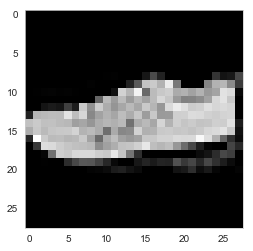

In [46]:
# Cada imagen tiene forma de tensor 1D con 28x28=784 elementos (cade elemento corresponde a un pixel en la imagen)

# Cojemos una imagen y cambiamos su forma a 28x28 para poder mostrarlo en la grafica
muestra_1 = fashion_mnist.train.images[0].reshape(28,28)

# Cojemos la etiqueta que corresponde
etiqueta_1 = np.where(fashion_mnist.train.labels[0] == 1)[0][0]

# Mostramos el ejemplo
print(f"Etiqueta: {class_names[etiqueta_1]}")
plt.imshow(muestra_1, cmap="gist_gray")
plt.grid(False)

# Placeholders

In [24]:
def crear_placeholders(nuestra_x, nuestra_y):
    
    # Argumentos:
    #  nuestra_x -- escalar, tamaño de un vector de imagen (28 * 28 = 784)
    #  nuestra_y -- escalar, número de clases (10)
    
    x = tf.placeholder(tf.float32, shape=[None, nuestra_x])
    y = tf.placeholder(tf.float32, shape=[None, nuestra_y])
    
    return x, y

# Variables (Inicializamos los parametros)

In [25]:
# Necesitamos inicializar los weights y biases de cada capa en nuestra red neuronal de 3 capas.
# Estos parámetros serán actualizados posteriormente durante el entrenamiento.

# Para inicializar nuestros weights usaremos Xavier inicializador.
# Para los biases inicialización Zero.

def inicializar_parametros():
    
    # Primera capa
    w1 = tf.get_variable("w1", [784, 128], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [1, 128], initializer=tf.zeros_initializer())
    
    # Segunda capa
    w2 = tf.get_variable("w2", [128, 128], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [1, 128], initializer=tf.zeros_initializer())
    
    # Capa de salida
    w3 = tf.get_variable("w3", [128, 10], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [1, 10], initializer=tf.zeros_initializer())
    
    # Almacenamos las inicializaciones como un diccionario de parámetros.
    parametros = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2,
        "w3": w3,
        "b3": b3
    }
    
    return parametros

# Operaciones (Forward propagation/Propagacion hacia adelante)

In [26]:
def forward_propagation(x, parametros):
    
    # Implementa la propagación hacia adelante del modelo:
    # LINEAL -> RELU -> LINEAL -> RELU -> LINEAL -> SOFTMAX
    
    # x -- entrada de datos placeholder, con forma (número de ejemplos, tamaño de la imagen)
    
    # Cojemos los parametros de nuestro diccionario
    w1 = parametros['w1']
    b1 = parametros['b1']
    w2 = parametros['w2']
    b2 = parametros['b2']
    w3 = parametros['w3']
    b3 = parametros['b3']
    
    # Hacemos nuestra propagacion hacia delante.
    z1 = tf.add(tf.matmul(x, w1), b1)
    a1 = tf.nn.relu(z1)                  
    z2 = tf.add(tf.matmul(a1, w2), b2)    
    a2 = tf.nn.relu(z2)                  
    z3 = tf.add(tf.matmul(a2, w3), b3)
    
    return z3

In [27]:
def save_model(session, file_name): 
    saver = tf.train.Saver()
    saver.save(session, f"/tmp/{file_name}")
    print("Modelo guardado")

# Loss function

In [28]:
def compute_loss(z, y_true):
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=z, labels=y_true))
    
    return loss

# Optimizer (Backpropagation)

In [29]:
def optimize(loss, learning_rate=0.001):
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

# Modelo (train_eval)

In [30]:
def modelo(train, test, learning_rate=0.001, num_epochs=16, minibatch_size=32, print_loss=True, graph_filename="loss", save_session=True):
    
    # Se asegura de que el modelo se puede volver a ejecutar sin sobrescribir las variables
    tf.reset_default_graph()
    
    # Cojemos las formas de nuestros inputs y outputs
    (cantidad_de_x, nuestra_x) = train.images.shape
    nuestra_y = train.labels.shape[1]    
    
    # Creamos nuestros placeholders
    x, y = crear_placeholders(nuestra_x, nuestra_y)
    
    losses = []
    
    # Inicializamos los parametros
    parametros = inicializar_parametros()
    
    # Propagacion hacia delante
    z3 = forward_propagation(x, parametros)
    
    # Nuestra perdida
    loss = compute_loss(z3, y)
    
    # Backpropagation usando Adam optimizer
    optimizer = optimize(loss)
    
    # Inicializamos las variables
    init = tf.global_variables_initializer()
    
    
    # Iniciamos sesion para calcular el grafico de Tensorflow
    with tf.Session() as sess:
        
        # Corremos la inicializacion
        sess.run(init)
        
        # Bucle para entrenamiento
        for epoch in range(num_epochs):
             
                epoch_loss = 0.
                cantidad_loops = int(cantidad_de_x / minibatch_size)
                
                for i in range(cantidad_loops):
                    
                    # Obtenemos el siguiente batch de datos de entrenamiento y etiquetas
                    minibatch_x, minibatch_y = train.next_batch(minibatch_size)
                    
                    # Ejecutamos optimizer y loss function
                    _, minibatch_loss = sess.run([optimizer, loss], feed_dict={x:minibatch_x, y:minibatch_y})
                    
                    # Actualizamos la perdida del epoch
                    epoch_loss += minibatch_loss / cantidad_loops
                
                if print_loss == True:
                    print(f"Perdida en epoch {epoch}: {epoch_loss}")
                    losses.append(epoch_loss)
        
        # Mostramos la grafica de perdida
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(losses), color='#2A688B')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("Perdida")
        plt.xlabel("Iteraciones")
        plt.title(f"Learning rate: {learning_rate}")
        plt.savefig(graph_filename, dpi=300)
        
        # Guardamos nuestros parametros entrenados
        parametros = sess.run(parametros)
        print("Parametros entrenados!")
        
        # Calculamos las predicciones que fueron correctas
        correct_prediction = tf.equal(tf.argmax(z3, 1), tf.argmax(y, 1))
        
        # Calculamos nuestra precision
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Evaluamos nuestro model.
        print("Train Accuracy: ", accuracy.eval({x: train.images, y: train.labels}))
        print("Test Accuracy: ", accuracy.eval({x: test.images, y: test.labels}))
        
        # Guardamos nuestra session.
        if save_session == True:
            save_model(sess, "fashion_mnist")
        
        return parametros

# Test del modelo

In [31]:
train = fashion_mnist.train
test = fashion_mnist.test

Perdida en epoch 0: 0.5017607870562677
Perdida en epoch 1: 0.3709262532254673
Perdida en epoch 2: 0.33517703862169035
Perdida en epoch 3: 0.3094527139041109
Perdida en epoch 4: 0.28868477690500866
Perdida en epoch 5: 0.2775624888180404
Perdida en epoch 6: 0.2626578527425732
Perdida en epoch 7: 0.2524849871418526
Perdida en epoch 8: 0.24010651209310313
Perdida en epoch 9: 0.23143474337437805
Perdida en epoch 10: 0.22236759326723254
Perdida en epoch 11: 0.21481862747597247
Perdida en epoch 12: 0.2071001122405315
Perdida en epoch 13: 0.20023142606479685
Perdida en epoch 14: 0.19139688118763215
Perdida en epoch 15: 0.18703257559871295
Parametros entrenados!
Train Accuracy:  0.93465453
Test Accuracy:  0.8893
Modelo guardado


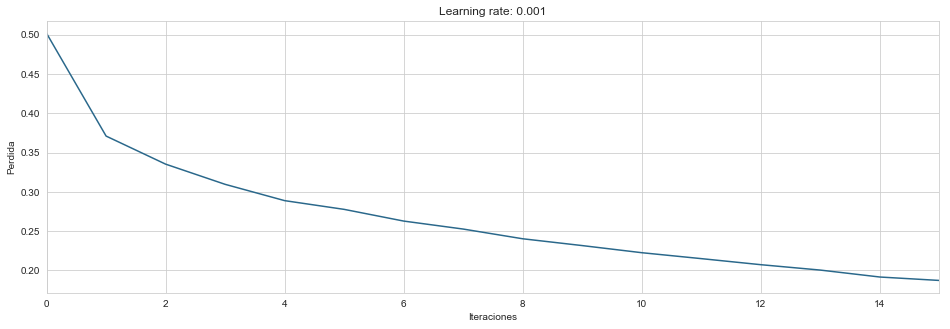

In [32]:
parameters = modelo(train, test, learning_rate=0.001)

 ## Predicciones

In [39]:
def predecir(imagenes):
    
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, shape=[None, 784])
    
    z3 = forward_propagation(x, parameters)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        predictions = sess.run([z3], feed_dict={x: imagenes})   
        
    return predictions
    

In [40]:
data_never_seen = fashion_mnist.test.images[6].reshape([1,784])
data_never_seen.shape

(1, 784)

Label: Abrigo


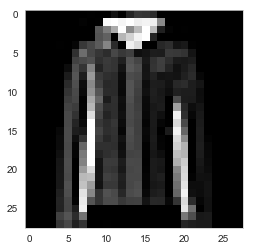

In [41]:
print(f"Label: {class_names[np.where(fashion_mnist.test.labels[6] == 1)[0][0]]}")
plt.imshow(fashion_mnist.test.images[6].reshape(28,28), cmap="gist_gray")
plt.grid(False)

In [42]:
predictions = predecir(data_never_seen)

In [43]:
predictions

[array([[-11.227413  , -14.854528  ,   4.465672  , -24.239819  ,
          14.316182  , -37.188786  ,   0.09367141, -31.071415  ,
         -22.759933  , -44.44107   ]], dtype=float32)]

In [44]:
print(f"Prediccion: {class_names[np.argmax(predictions)]}")

Prediccion: Abrigo
